In [27]:
import pandas as pd #import the libraries 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.special import betaln as lbeta
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline

In [28]:
data = pd.read_csv("./league_email_experiment.csv")
data.email[data.iloc[:, 1] == "A"] = 0
data.email[data.iloc[:, 1] == "B"] = 1

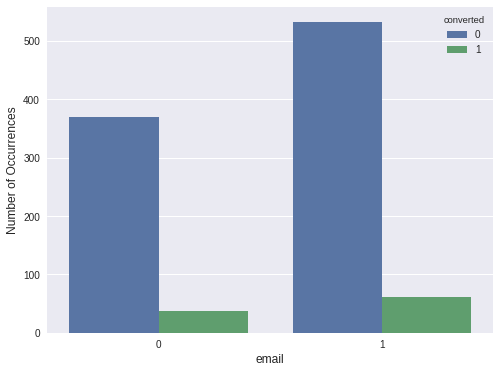

In [33]:
import seaborn as sns  #visualize email-type against target variable 
plt.figure(figsize=(8,6))

sns.countplot(x="email", hue='converted', data=data)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel("email", fontsize=12)
plt.show()

#### We can see that campaign B does slightly better from the plot.

#### Now, to try another approach, we can use the data in regression model to see which feature is more important, email type A or B.

In [44]:
interX_lm = ols("converted ~ email ", data).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4735
Date:                Sat, 13 Jan 2018   Prob (F-statistic):              0.492
Time:                        14:04:09   Log-Likelihood:                -210.26
No. Observations:                1000   AIC:                             424.5
Df Residuals:                     998   BIC:                             434.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0911      0.015      6.144      0.0

#### From the summary of linear model, we can see, email[1] which is email type B, is a more important feature. 

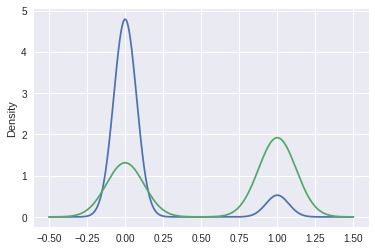

In [46]:
data["converted"].plot(kind="density") # density plot, for b(green) is more dispersed 
data["email"].plot(kind="density")

In [36]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
            for cat2 in categories(df_col2)]
            for cat1 in categories(df_col1)]
    
    print("i", result)
    return scs.chi2_contingency(result)


#test_df = pd.read_csv('test_data_for_chi_square.csv')
print(list(chi_square_of_df_cols(data, 'email', 'converted')[0:2]))
pd.DataFrame(chi_square_of_df_cols(data, 'email', 'converted')[3])

i [[369, 37], [532, 62]]
[0.33738262943708697, 0.561343928069854]
i [[369, 37], [532, 62]]


,0,1
0,365.806,40.194
1,535.194,58.806


In [37]:
data["email"][data["converted"] == 1].value_counts()

# conversions B 62 over 594
# conversions A 37 over 406
#2    594
#1    406

1    62
0    37
Name: email, dtype: int64

In [38]:
# Beta Distribution approach.

In [39]:
def probability_B_beats_A(a_A, b_A, a_B, b_B):
    total = 0.0
    for i in range(a_B):
        total += exp(lbeta(a_A+i, b_B+b_A) - log(b_B+i) - lbeta(1+i, b_B) - lbeta(a_A, b_A))
    return total
probability_B_beats_A(38, 407 - 37, 63, 595 - 62)

0.74731094429250211

In [227]:
import scipy.stats as stats
e_tab = pd.crosstab(data.email, data.converted, margins = True)
e_tab.columns = ["No","Yes","row_totals"]
e_tab.index = ["A","B","column_totals"]
obs = e_tab.ix[0:2,0:2]

exp =  np.outer(e_tab["row_totals"][0:2], e_tab.ix["column_totals"][0:2]) / 1000
exp = pd.DataFrame(exp)
exp.columns = ["No","Yes"]
exp.index = ["A","B"]
e_tab ## Contigency table 


,No,Yes,row_totals
A,369,37,406
B,532,62,594
column_totals,901,99,1000


#### Email A had 406 occurences and 36 conversions and email B had 594 occurences and 62 conversions.

 [-----------------100%-----------------] 1000000 of 1000000 complete in 65.3 sec

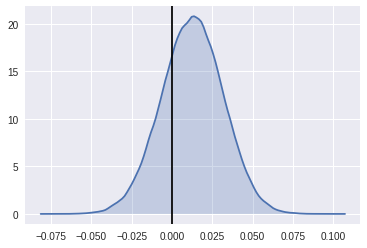

In [42]:
import pymc
values_A = np.hstack(([0]*(406-37),[1]*37))
values_B = np.hstack(([0]*(594-62),[1]*62))
# set uniform priors 
p_A = pymc.Uniform('p_A', 0, 1)
p_B = pymc.Uniform('p_B', 0, 1)

#init delta distribution 
@pymc.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_B - p_A

# Create the Bernoulli variables for the observation
obs_A = pymc.Bernoulli('obs_A', p_A, value = values_A , observed = True)
obs_B = pymc.Bernoulli('obs_B', p_B, value = values_B , observed = True)


# Create the model and run the sampling
model = pymc.Model([p_A, p_B, delta, values_A, values_B])
mcmc = pymc.MCMC(model)
# Sample 1,000,000 million points and throw out the first 500,000 since it takes time to converge
mcmc.sample(1000000, 500000)
delta_distribution = mcmc.trace('delta')[:]
sns.kdeplot(delta_distribution, shade = True)
plt.axvline(0.00, color = 'black')

In [43]:
print("Probability that email type A gets MORE sign-ups than type B: %0.3f" % (delta_distribution < 0).mean())
print("Probability that email type A gets LESS sign-ups than type B: %0.3f" % (delta_distribution > 0).mean())

Probability that email type A gets MORE sign-ups than type B: 0.255
Probability that email type A gets LESS sign-ups than type B: 0.745


## Predictive Modeling 

In [63]:
data.drop("user_id", axis=1,inplace=True)

In [216]:
from time import time
from sklearn.model_selection import train_test_split

X = data.iloc[:,2:]
y = data["converted"] ## initialize x and Y, drop id column 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.30)

In [222]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import xgboost as XGB

def get_model(estimator, parameters, X_train, y_train, scoring):  
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_

scoring = make_scorer(mean_absolute_error, greater_is_better=False)

xgb = XGB.XGBClassifier(seed=42, max_depth=5, objective='binary:logistic')
parameters = {'learning_rate':[0.1,0.01], 'reg_alpha':[3.0], 'reg_lambda': [4.0], 'n_estimators':[100, 400,500]}
clf_xgb1 = get_model(xgb, parameters, X_train, y_train, scoring)



In [223]:
from sklearn.metrics import classification_report
print (classification_report(y_test, clf_xgb1.predict(X_test)))
print (clf_xgb1)
# F1-Score 0.68 

             precision    recall  f1-score   support

          0       0.95      1.00      0.97       270
          1       0.94      0.53      0.68        30

avg / total       0.95      0.95      0.94       300

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=3.0, reg_lambda=4.0, scale_pos_weight=1, seed=42,
       silent=True, subsample=1)


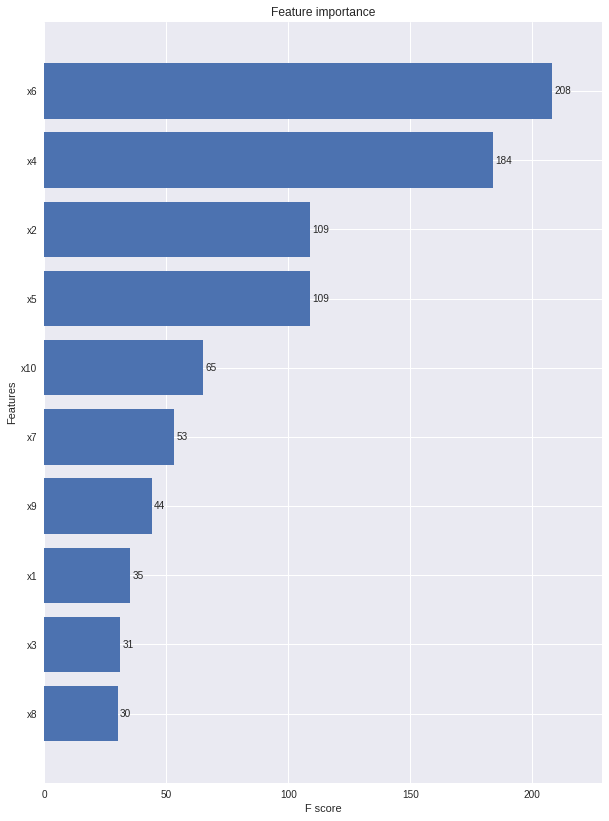

In [224]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,14))
plot_importance(clf_xgb1, height=0.8, ax=ax)
plt.show()

In [213]:
from sklearn.metrics import make_scorer, accuracy_score , mean_absolute_error 
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def get_model(estimator, parameters, X_train, y_train, scoring):  
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_

parameters = {"max_depth": [2,3,4,5]
            ,"min_samples_split" :[2,3,4]
            ,"n_estimators" : [10, 100, 500]
            ,"min_samples_leaf": [3,4,5]
            ,"max_features": (4,5,6,"sqrt")
            ,"criterion":['gini']}

rf_regr = RandomForestClassifier()
rclf = GridSearchCV(rf_regr,parameters, n_jobs = 6, cv = 5)
rclf = rclf.fit(X_train,y_train)

In [214]:
# make predictions
y_p = rclf.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(y_test, y_p))
print(metrics.confusion_matrix(y_test, y_p))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       297
          1       1.00      0.45      0.62        33

avg / total       0.95      0.95      0.94       330

[[297   0]
 [ 18  15]]


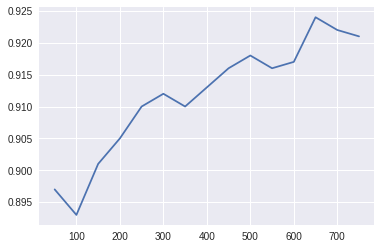

In [229]:
n_estimators = 100
forest = RandomForestClassifier(warm_start=True, oob_score=True)
kvs = {}
for i in range(1, 16):
    n_estimators = n_estimators + i*30
    forest.set_params(n_estimators=i)
    forest.fit(X, y)
    kvs[i] = forest.oob_score_
lists = sorted(kvs.items()) # sorted by key, return a list of tuples
a, b = zip(*lists) # unpack a list of pairs into two tuples
a = [i * 50 for i in a]
plt.plot(a, b)
plt.show() ## around 650 is the beest number of trees

In [170]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

#0.94      0.53      0.68        30
# 1-True cases F1 score is much better. 

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       270
          1       0.89      0.57      0.69        30

avg / total       0.95      0.95      0.94       300

[[268   2]
 [ 13  17]]


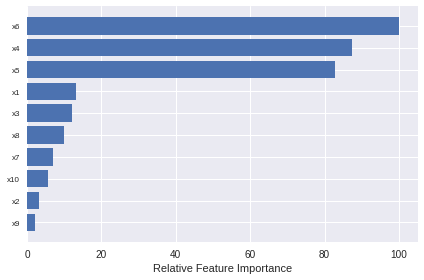

In [178]:
feature_importance = abs(lg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featfig.figsize=(12,16)
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()



In [179]:
np.array(X.columns)[sorted_idx]

array(['x9', 'x2', 'x10', 'x7', 'x8', 'x3', 'x1', 'x5', 'x4', 'x6'], dtype=object)

In [195]:
from sklearn.preprocessing import PolynomialFeatures, scale 

Xs_train = scale(X_train)
Xs_test = scale(X_test)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only = True)
poly_xtr =poly.fit_transform(Xs_train)
poly_xts =poly.fit_transform(Xs_test)

classifier = LogisticRegression(penalty ='l2', max_iter = 200)
classifier.fit(poly_xtr, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [197]:
y_pred1 = classifier.predict(poly_xts)
print(metrics.classification_report(y_test, y_pred1))
print(metrics.confusion_matrix(y_test, y_pred1))

             precision    recall  f1-score   support

          0       0.95      0.98      0.97       270
          1       0.74      0.57      0.64        30

avg / total       0.93      0.94      0.93       300

[[264   6]
 [ 13  17]]


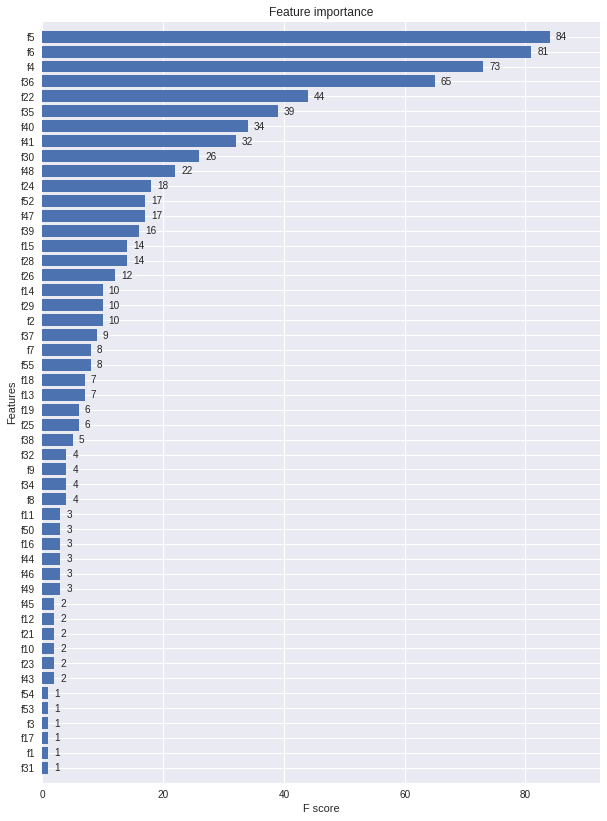

In [200]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,14))
plot_importance(clf_xgb1, height=0.8, ax=ax)
plt.show()

#### references 
#### http://www.evanmiller.org/bayesian-ab-testing.html
#### https://classroom.udacity.com/courses/ud257/lessons/4018018619/concepts/40043986890923